# Regress Litter on Deprivation in Glasgow City

## Load Data

In [1]:
import pandas as pd

data_fpath = "../glasgow-simd2020v2.csv"

df = pd.read_csv(data_fpath, header=0)
n_rows = len(df.index)
n_columns = len(df.columns)

print(f"There are {n_rows} observations and {n_columns} features.")
print("The features are:", end="\n\n")
for i, feature in enumerate(df.columns.values):
  print(f"{i+1}. {feature}")

There are 746 observations and 50 features.
The features are:

1. Data_Zone
2. Intermediate_Zone
3. litter
4. Council_area
5. Total_population
6. Working_Age_population
7. SIMD2020v2_Rank
8. SIMD_2020v2_Percentile
9. SIMD2020v2_Vigintile
10. SIMD2020v2_Decile
11. SIMD2020v2_Quintile
12. SIMD2020v2_Income_Domain_Rank
13. SIMD2020_Employment_Domain_Rank
14. SIMD2020_Health_Domain_Rank
15. SIMD2020_Education_Domain_Rank
16. SIMD2020_Access_Domain_Rank
17. SIMD2020_Crime_Domain_Rank
18. SIMD2020_Housing_Domain_Rank
19. income_rate
20. income_count
21. employment_rate
22. employment_count
23. CIF
24. ALCOHOL
25. DRUG
26. SMR
27. DEPRESS
28. LBWT
29. EMERG
30. Attendance
31. Attainment
32. no_qualifications
33. not_participating
34. University
35. crime_count
36. crime_rate
37. overcrowded_count
38. nocentralheating_count
39. overcrowded_rate
40. nocentralheating_rate
41. drive_petrol
42. drive_GP
43. drive_post
44. drive_primary
45. drive_retail
46. drive_secondary
47. PT_GP
48. PT_post
49.

## Handle Missing Data

In [2]:
import numpy as np

def print_missing_data_count(df):
  missing_data = df[df.isnull().any(axis=1)]
  missing_data_rows = len(missing_data)
  print(f"There are {missing_data_rows} observations with missing data.")

df = df.replace("*", np.NaN)
print_missing_data_count(df)

df = df.fillna(0)
print_missing_data_count(df)

There are 105 observations with missing data.
There are 0 observations with missing data.


## Inspect Feature Data Types

In [197]:
df.dtypes

Data_Zone                           object
Intermediate_Zone                   object
Council_area                        object
Total_population                     int64
Working_Age_population               int64
SIMD2020v2_Rank                      int64
SIMD_2020v2_Percentile               int64
SIMD2020v2_Vigintile                 int64
SIMD2020v2_Decile                    int64
SIMD2020v2_Quintile                  int64
SIMD2020v2_Income_Domain_Rank      float64
SIMD2020_Employment_Domain_Rank    float64
SIMD2020_Health_Domain_Rank          int64
SIMD2020_Education_Domain_Rank       int64
SIMD2020_Access_Domain_Rank          int64
SIMD2020_Crime_Domain_Rank         float64
SIMD2020_Housing_Domain_Rank       float64
income_rate                         object
income_count                         int64
employment_rate                     object
employment_count                     int64
CIF                                float64
ALCOHOL                            float64
DRUG       

In [3]:
to_category_features = ["Data_Zone", "Intermediate_Zone", "Council_area"]
for feature in to_category_features:
  df[feature] = df[feature].astype("category")

to_float_features = [
  "income_rate",
  "employment_rate",
  "crime_rate",
  "DEPRESS",
  "LBWT",
  "Attendance",
  "not_participating",
  "University",
  "overcrowded_rate",
  "nocentralheating_rate",
  "broadband",
  "crime_count",
  "Attainment"
]
for feature in to_float_features:
  df[feature] = df[feature].str.rstrip("%").astype(float) / 100

df.dtypes

Data_Zone                          category
Intermediate_Zone                  category
litter                                int64
Council_area                       category
Total_population                      int64
Working_Age_population                int64
SIMD2020v2_Rank                       int64
SIMD_2020v2_Percentile                int64
SIMD2020v2_Vigintile                  int64
SIMD2020v2_Decile                     int64
SIMD2020v2_Quintile                   int64
SIMD2020v2_Income_Domain_Rank       float64
SIMD2020_Employment_Domain_Rank     float64
SIMD2020_Health_Domain_Rank           int64
SIMD2020_Education_Domain_Rank        int64
SIMD2020_Access_Domain_Rank           int64
SIMD2020_Crime_Domain_Rank          float64
SIMD2020_Housing_Domain_Rank        float64
income_rate                         float64
income_count                          int64
employment_rate                     float64
employment_count                      int64
CIF                             

## Summarise

In [199]:
df.describe()

,Total_population,Working_Age_population,SIMD2020v2_Rank,SIMD_2020v2_Percentile,SIMD2020v2_Vigintile,SIMD2020v2_Decile,SIMD2020v2_Quintile,SIMD2020v2_Income_Domain_Rank,SIMD2020_Employment_Domain_Rank,SIMD2020_Health_Domain_Rank,SIMD2020_Education_Domain_Rank,SIMD2020_Access_Domain_Rank,SIMD2020_Crime_Domain_Rank,SIMD2020_Housing_Domain_Rank,income_rate,income_count,employment_rate,employment_count,CIF,ALCOHOL,DRUG,SMR,DEPRESS,LBWT,EMERG,Attendance,Attainment,no_qualifications,not_participating,University,crime_count,crime_rate,overcrowded_count,nocentralheating_count,overcrowded_rate,nocentralheating_rate,drive_petrol,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,745.000000,745.000000,746.000000,660.000000,700.000000,746.000000,743.000000,744.000000,739.000000,738.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,744.000000,746.00000
mean,832.466488,587.012064,2356.975871,34.282842,7.269437,3.912869,2.262735,2210.412198,2429.540214,2223.316354,2548.072386,4775.954424,2322.624665,1258.886729,0.197922,160.512064,0.142386,78.249330,151.930295,175.747989,157.664879,124.231903,0.211302,0.059047,121.682306,0.764939,0.054042,149.883847,0.044616,0.088629,0.368823,4.445881,165.180965,25.206434,0.213941,0.032319,3.110450,2.346055,2.346497,2.630558,3.539734,4.231587,7.098030,7.079232,9.656767,0.015538,48.89008
std,249.111693,226.292407,2083.181465,29.850575,5.959690,2.947263,1.425795,1970.824622,2075.072254,2041.083778,2016.797057,1599.093704,1659.104951,1376.590255,0.122181,104.359384,0.091223,51.953924,72.565826,143.252209,169.481753,66.867021,0.067639,0.044335,43.282244,0.085507,0.005155,72.495284,0.039181,0.068327,0.560351,6.509244,78.661338,22.488005,0.092998,0.028804,1.123736,1.045879,0.829226,0.889530,1.332983,1.337981,3.066340,2.520782,3.464514,0.050950,22.57001
min,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,796.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.430000,0.033600,11.000000,0.000000,0.000000,0.030000,0.440000,19.000000,0.000000,0.030000,0.000000,0.870548,0.664751,0.667906,0.979924,0.843476,1.290801,1.595565,1.831674,2.289857,0.000000,5.00000
25%,683.500000,450.250000,500.250000,8.000000,2.000000,1.000000,1.000000,479.250000,557.000000,425.500000,811.500000,3658.000000,928.500000,340.500000,0.090000,69.000000,0.060000,33.000000,90.000000,71.250000,38.250000,87.000000,0.160000,0.030000,89.000000,0.710000,0.050400,90.000000,0.010000,0.040000,0.160000,2.047500,109.250000,10.000000,0.150000,0.010000,2.247843,1.568119,1.732829,1.999866,2.622112,3.239094,4.859224,5.281409,7.071742,0.000000,32.00000
50%,808.500000,552.000000,1690.000000,25.000000,5.000000,3.000000,2.000000,1554.500000,1887.000000,1553.500000,2024.500000,5051.000000,2014.000000,777.000000,0.190000,150.500000,0.130000,69.500000,155.000000,148.000000,110.500000,115.000000,0.210000,0.060000,118.500000,0.770000,0.054100,153.000000,0.040000,0.070000,0.260000,3.270000,155.000000,19.000000,0.210000,0.030000,2.973391,2.122786,2.242858,2.507080,3.392009,4.081267,6.719505,6.792529,9.250142,0.000000,45.00000
75%,939.000000,669.000000,4048.500000,58.750000,12.000000,6.000000,3.000000,3712.250000,4120.500000,3659.750000,3935.500000,6135.750000,3405.500000,1577.250000,0.290000,237.000000,0.210000,113.000000,205.000000,240.000000,227.750000,147.000000,0.260000,0.090000,150.000000,0.820000,0.057300,206.000000,0.070000,0.110000,0.430000,5.200000,216.000000,34.000000,0.260000,0.040000,3.937484,2.976169,2.871751,3.084471,4.388052,5.065079,8.865254,8

## Split Data

In [4]:
df_train, df_valid, df_test = np.split(df.sample(frac=1, random_state=1), [int(.7*len(df)), int(.9*len(df))])

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


## Model 1: Poisson (All Features)

### Train

In [6]:
from patsy import dmatrices
import statsmodels.api as sm

model_expr = "litter ~ Total_population + Working_Age_population + income_rate + income_count + employment_rate + employment_count + CIF + ALCOHOL + DRUG + SMR + DEPRESS + LBWT + EMERG + Attendance + Attainment + no_qualifications + not_participating + University + crime_count + crime_rate + overcrowded_rate + nocentralheating_rate + drive_petrol + drive_GP + drive_post + drive_primary + drive_retail + drive_secondary + PT_GP + PT_post + PT_retail + broadband"

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

model_train = sm.GLM(y_train, X_train, family=sm.families.Poisson())
results_train = model_train.fit()

model_lambda = results_train.mu

results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 litter   No. Observations:                  459
Model:                            GLM   Df Residuals:                      426
Model Family:                 Poisson   Df Model:                           32
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2903.2
Date:                Tue, 28 Dec 2021   Deviance:                       3210.7
Time:                        14:56:47   Pearson chi2:                 3.16e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9638
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.4452      0.162     21.258      0.000       3.128       3.763
Total_population          -0.0001      0.000     -0.602      0.547      -0.001       0.000
Working_Age_population     0.0004      0.000      1.870      0.061   -2.01e-05       0.001
income_rate                1.9751      0.643      3.072      0.002       0.715       3.235
income_count              -0.0011      0.001     -1.442      0.149      -0.003       0.000
employment_rate           -0.1441      0.727     -0.198      0.843      -1.569       1.280
employment_count          -0.0005      0.001     -0.368      0.713      -0.003       0.002
CIF                        0.0011      0.000      2.759      0.006       0.000       0.002
ALCOHOL                    0.0004   7.71e-05      5.560      0.000       0.000       0.001
DRUG                      -0.0001   5.83e-05     -2.329      0.020      -0.000   -2.15e-05
SMR                       -0.0005      0.000     -4.103      0.000      -0.001      -0.000
DEPRESS                    0.2510      0.232      1.080      0.280      -0.205       0.707
LBWT                      -0.1886      0.162     -1.167      0.243      -0.505       0.128
EMERG                     -0.0015      0.000     -4.075      0.000      -0.002      -0.001
Attendance                -0.1686      0.120     -1.407      0.160      -0.404       0.066
Attainment                 3.3729      1.921      1.756      0.079      -0.393       7.138
no_qualifications          0.0014      0.000      5.058      0.000       0.001       0.002
not_participating         -0.5948      0.242     -2.458      0.014      -1.069      -0.121
University                -0.5055      0.197     -2.561      0.010      -0.892      -0.119
crime_count                0.1146      0.111      1.028      0.304      -0.104       0.333
crime_rate                -0.0209      0.009     -2.421      0.015      -0.038      -0.004
overcrowded_rate           0.7126      0.137      5.217      0.000       0.445       0.980
nocentralheating_rate     -0.0506      0.300     -0.169      0.866      -0.638       0.537
drive_petrol              -0.0178      0.007     -2.531      0.011      -0.032      -0.004
drive_GP                  -0.0174      0.016     -1.070      0.284      -0.049       0.014
drive_post                -0.0330      0.016     -2.013      0.044      -0.065      -0.001
drive_primary             -0.0446      0.010     -4.576      0.000      -0.064      -0.025
drive_retail               0.0016      0.010      0.164      0.870      -0.018       0.021
drive_secondary            0.0177      0.005      3.310      0.001       0.007       0.028
PT_GP                      0.0038      0.006      0.678      0.498      -0.007       0.015
PT_post                   -0.0053      0.006     -0.930      0.353      -0.017  

### Predict

In [202]:
predictions = results_train.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

print(predicted_counts)

326    47.0
458    58.0
465    47.0
167    45.0
145    44.0
       ... 
243    43.0
87     58.0
678    67.0
418    48.0
288    65.0
Name: mean, Length: 123, dtype: float64


### Evaluate

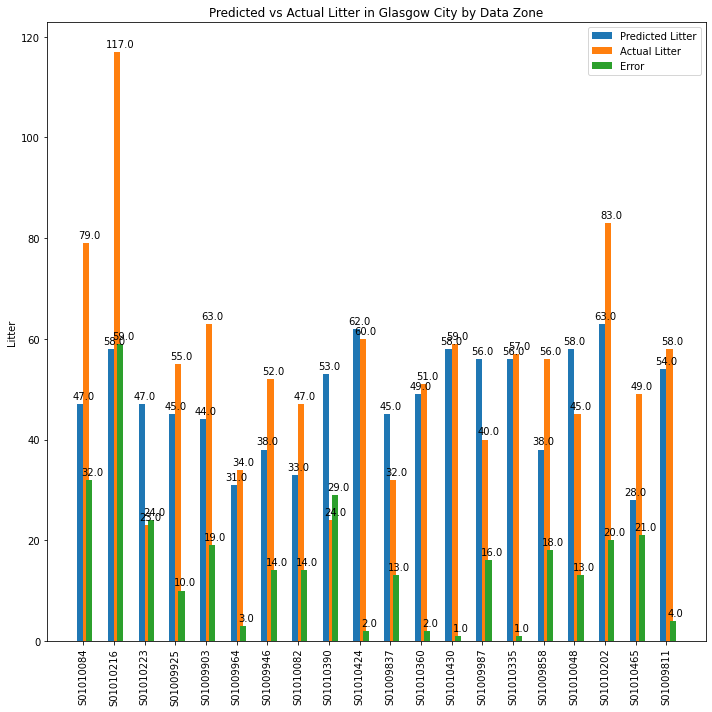

In [235]:
import matplotlib.pyplot as plt

n_bars = 20
indices = X_valid.index[:n_bars]
labels = df.iloc[indices]["Data_Zone"]
y_predicted = predicted_counts[:n_bars]
y_actual = actual_counts[:n_bars]
y_err = abs(y_predicted - y_actual)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
x = np.arange(len(labels))
bar_width = 0.2
rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
ax.set_ylabel("Litter")
ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height}",
            xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center", va='bottom'
        )

fig.tight_layout()
plt.show()

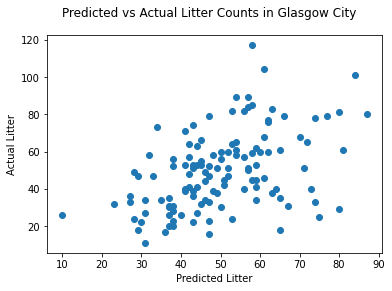

In [236]:
fig.clear()

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()

## Model 2: Poisson (Significant Features)

In [7]:
model_expr = "litter ~ Total_population + Working_Age_population + income_count + employment_rate + employment_count + SMR + University + crime_count + crime_rate + overcrowded_rate + drive_petrol + drive_primary + drive_secondary + PT_post + broadband"

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

model_train = sm.GLM(y_train, X_train, family=sm.families.Poisson())
results_train = model_train.fit()

model_lambda = results_train.mu

results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 litter   No. Observations:                  519
Model:                            GLM   Df Residuals:                      503
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3338.2
Date:                Tue, 28 Dec 2021   Deviance:                       3754.8
Time:                        14:56:52   Pearson chi2:                 3.72e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9535
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.7359      0.061     61.598      0.000       3.617       3.855
Total_population          -0.0006      0.000     -4.342      0.000      -0.001      -0.000
Working_Age_population     0.0007      0.000      5.329      0.000       0.000       0.001
income_count               0.0016      0.000      6.158      0.000       0.001       0.002
employment_rate            2.8596      0.240     11.918      0.000       2.389       3.330
employment_count          -0.0050      0.001     -9.465      0.000      -0.006      -0.004
SMR                       -0.0003      0.000     -3.062      0.002      -0.001      -0.000
University                -0.8533      0.129     -6.611      0.000      -1.106      -0.600
crime_count                0.2534      0.070      3.599      0.000       0.115       0.391
crime_rate                -0.0238      0.006     -3.899      0.000      -0.036      -0.012
overcrowded_rate           0.8970      0.097      9.283      0.000       0.708       1.086
drive_petrol              -0.0115      0.006     -1.989      0.047      -0.023      -0.000
drive_primary             -0.0145      0.008     -1.813      0.070      -0.030       0.001
drive_secondary            0.0119      0.005      2.454      0.014       0.002       0.021
PT_post                   -0.0177      0.003     -6.230      0.000      -0.023      -0.012
broadband                 -0.2993      0.136     -2.199      0.028      -0.566      -0.032
==========================================================================================
"""

In [239]:
predictions = results_train.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

print(predicted_counts)

326    44.0
458    60.0
465    52.0
163    46.0
167    48.0
       ... 
87     62.0
655    29.0
678    67.0
418    45.0
288    66.0
Name: mean, Length: 147, dtype: float64


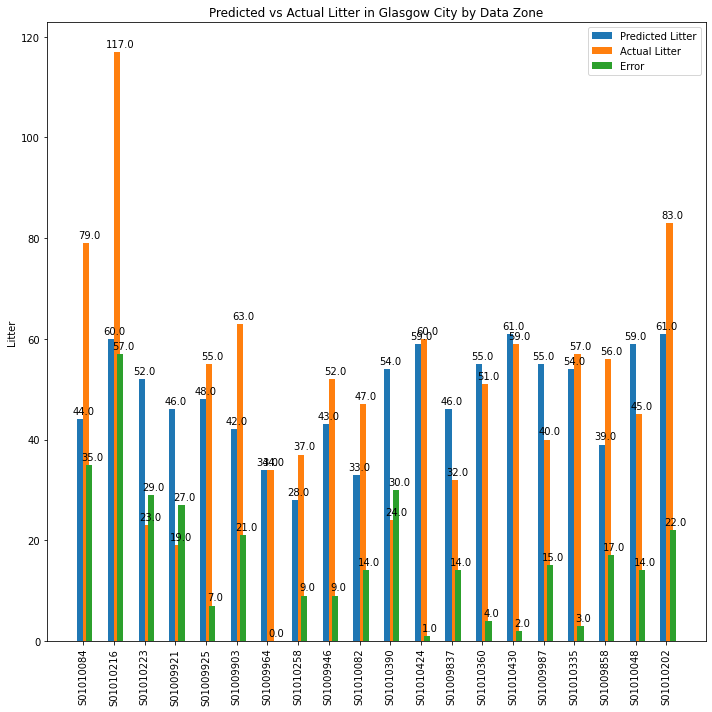

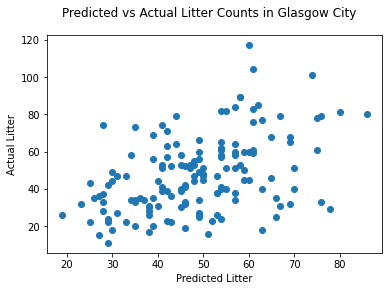

In [241]:
n_bars = 20
indices = X_valid.index[:n_bars]
labels = df.iloc[indices]["Data_Zone"]
y_predicted = predicted_counts[:n_bars]
y_actual = actual_counts[:n_bars]
y_err = abs(y_predicted - y_actual)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
x = np.arange(len(labels))
bar_width = 0.2
rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
ax.set_ylabel("Litter")
ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height}",
            xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center", va='bottom'
        )

fig.tight_layout()
plt.show()

fig.clear()

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()

## Model 3: Negative Binomial (NB2)

In [8]:
import statsmodels.formula.api as smf

df_train_nb = df_train.copy()
df_train_nb = df_train.loc[X_train.index]

df_train_nb["litter_lambda"] = model_lambda
df_train_nb["aux_ols_dep"] = df_train_nb.apply(lambda x: ((x["litter"] - x["litter_lambda"])**2 - x["litter_lambda"]) / x["litter_lambda"], axis=1)

aux_olsr_results = smf.ols("aux_ols_dep ~ litter_lambda - 1", df_train_nb).fit()
print(aux_olsr_results.params)
print(aux_olsr_results.tvalues)

litter_lambda    0.127854
dtype: float64
litter_lambda    13.591442
dtype: float64


In [35]:
model_expr = "litter ~ Total_population + Working_Age_population + income_rate + income_count + employment_rate + employment_count + CIF + ALCOHOL + DRUG + SMR + DEPRESS + LBWT + EMERG + Attendance + Attainment + no_qualifications + not_participating + University + crime_count + crime_rate + overcrowded_rate + nocentralheating_rate + drive_petrol + drive_GP + drive_post + drive_primary + drive_retail + drive_secondary + PT_GP + PT_post + PT_retail + broadband"

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

alpha = aux_olsr_results.params["litter_lambda"]

model_train = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha))
results_train = model_train.fit()

results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 litter   No. Observations:                  459
Model:                            GLM   Df Residuals:                      426
Model Family:        NegativeBinomial   Df Model:                           32
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1974.9
Date:                Tue, 28 Dec 2021   Deviance:                       493.54
Time:                        14:52:02   Pearson chi2:                     453.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3887
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.4429      0.429      8.021      0.000       2.602       4.284
Total_population       -5.184e-05      0.001     -0.097      0.923      -0.001       0.001
Working_Age_population     0.0003      0.001      0.586      0.558      -0.001       0.001
income_rate                2.0428      1.670      1.223      0.221      -1.231       5.316
income_count              -0.0011      0.002     -0.556      0.578      -0.005       0.003
employment_rate           -0.3711      1.942     -0.191      0.848      -4.178       3.435
employment_count          -0.0006      0.003     -0.192      0.848      -0.007       0.006
CIF                        0.0013      0.001      1.184      0.237      -0.001       0.003
ALCOHOL                    0.0004      0.000      1.943      0.052    -3.6e-06       0.001
DRUG                   -9.696e-05      0.000     -0.608      0.543      -0.000       0.000
SMR                       -0.0004      0.000     -1.260      0.208      -0.001       0.000
DEPRESS                    0.2005      0.612      0.327      0.743      -1.000       1.401
LBWT                      -0.1432      0.426     -0.336      0.737      -0.979       0.693
EMERG                     -0.0017      0.001     -1.730      0.084      -0.004       0.000
Attendance                -0.1888      0.323     -0.585      0.559      -0.822       0.444
Attainment                 3.9040      5.094      0.766      0.443      -6.081      13.889
no_qualifications          0.0015      0.001      2.123      0.034       0.000       0.003
not_participating         -0.4752      0.653     -0.728      0.467      -1.755       0.805
University                -0.4416      0.493     -0.895      0.371      -1.409       0.525
crime_count                0.1038      0.278      0.374      0.709      -0.440       0.648
crime_rate                -0.0166      0.021     -0.807      0.420      -0.057       0.024
overcrowded_rate           0.5771      0.366      1.575      0.115      -0.141       1.295
nocentralheating_rate      0.1616      0.801      0.202      0.840      -1.408       1.731
drive_petrol              -0.0179      0.018     -0.976      0.329      -0.054       0.018
drive_GP                  -0.0227      0.042     -0.534      0.593      -0.106       0.061
drive_post                -0.0158      0.042     -0.372      0.710      -0.099       0.067
drive_primary             -0.0478      0.025     -1.911      0.056      -0.097       0.001
drive_retail              -0.0050      0.027     -0.186      0.853      -0.058       0.048
drive_secondary            0.0185      0.014      1.296      0.195      -0.009       0.046
PT_GP                      0.0024      0.015      0.159      0.873      -0.027       0.032
PT_post                   -0.0080      0.015     -0.535      0.592      -0.037  